# gonorrhoea 박테리아의 항생제 내성을 가지는 유전자 위치 ML로 예측하기  

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns
import time

## metadata와 rtab의 교집합 추출

In [3]:
def prep_data(phenotype) :   #metadata.csv와 .Rtab파일에서의 SeqID가 동일한 데이터셋을 추출 및 가공
    pheno = pd.read_csv('metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype])
    pheno = pheno[phenotype]   #내성여부를 1/0으로 표시하는 칼럼이 들어갈 예정
        
    X = pd.read_csv(phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] 
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

In [4]:
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)

performance = []
method = []
times = []

In [5]:
print(pheno.shape)  #=X.shpae
print(pheno)

print(X.shape)
print(X.iloc[:10,:10])

(3478,)
Sample_ID
ERR1549286    1.0
ERR1549290    1.0
ERR1549291    1.0
ERR1549287    1.0
ERR1549288    1.0
             ... 
ERR2172350    1.0
ERR2172351    1.0
ERR2172352    1.0
ERR2172353    1.0
ERR2172354    0.0
Name: azm_sr, Length: 3478, dtype: float64
(3478, 515)
pattern_id  CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  ...  TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC
ERR1549286                                                0  ...                                          0
ERR1549290                                                0  ...                                          0
ERR1549291                                                0  ...                                          0
ERR1549287                                                0  ...                                          0
ERR1549288                                                0  ...                                          0
ERR1549299                                                0  ...                 

In [10]:
pheno.value_counts()   #** 내성이 없는 변이 >> 내성이 있는 변이

0.0    3031
1.0     447
Name: azm_sr, dtype: int64

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


/Users/kimjoonsu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

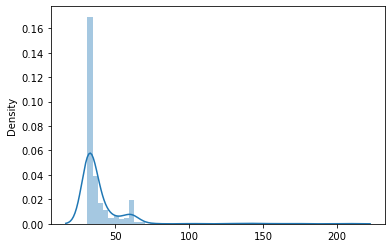

In [15]:
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sns.distplot(uni_len, bins = 50)  #대부분의 uniting의 길이는 25~30bp정도 